In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#sys.path.append('C:\\Users\\elisa\\Documents\\git\\mplstereonet')
sys.path.append('../../..')
import mplstereonet
import gempy as gp
#from importlib import reload
import os
#sys.path.append('C:\\Users\\elisa\\Documents\\git\\remote-geomod')  # append local path to access rgeomod module
import pandas as pn

#import rgeomod

#import gdal
import skimage
import scipy
import linecache
from mpl_toolkits.mplot3d import Axes3D
from copy import copy

import seaborn as sns

../../../gempy/data_management.py:34: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_504em20o.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)
../../../gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulatio

- Model 1: fault orientation uncertain 
- Model 2: fault location of fault_NWSE equally likely within 200m 
- Model 3a-d: formation orientation
- Model 4a-d: formation and fault orientation
- Model 5a-d: formation and fault orientation, fault location

| Model num | fault pos | fault orient | form orient | path_i | path_o | remark |
|-----------|-----------|--------------|-------------|--------|--------| |
| 1 |-|y|-| all_points  | Foliations_clust20_nl  |faultsonly|
|-----------|-----------|--------------|-------------|--------|--------||
| 2 |y|-|-|  ? |  all_foliations ||
|-----------|-----------|--------------|-------------|--------|--------||
| 3a|-|-|y|all_points|Foliations_clust20_nf|save|
| 3b|-|-|y|all_points|Foliations_clust21_nf|save|
| 3c|-|-|y|all_points|Foliations_clust22_nf|save|
|-----------|-----------|--------------|-------------|--------|--------||
| 4a|-|y|y|all_points|Foliations_clust20|save|
| 4b|-|y|y|all_points|Foliations_clust21|save|
| 4c|-|y|y|all_points|Foliations_clust22|save|
|-----------|-----------|--------------|-------------|--------|--------||
| 5a|y|y|y|?|Foliations_clust20|
| 5b|y|y|y|?|Foliations_clust21|
| 5c|y|y|y|?|Foliations_clust22|
|-----------|-----------|--------------|-------------|--------|--------||
| 6|-|-|-|all_points|Foliations_subj (based on clust21)|save|

In [2]:
model_num, param = 6,'b'

In [3]:
if model_num == 1:
    path_interf = 'all_points.csv'
    path_orient = 'Foliations_clust20_nl.csv'
    print('faults only')

elif model_num == 6:
    path_interf = 'all_points.csv'
    path_orient = 'Foliations_subj.csv'
    
elif model_num == 2:
    path_interf = None
    path_orient = 'all_foliations.csv'
    
elif model_num == 3:
    path_interf = 'all_points.csv'
    if param == 'a':
        path_orient = 'Foliations_clust20_nf.csv'
    elif param == 'b':
        path_orient = 'Foliations_clust21_nf.csv'
    elif param == 'c':
        path_orient = 'Foliations_clust22_nf.csv'
        
elif (model_num == 4) or (model_num == 5):
    if param == 'a':
        path_orient = 'Foliations_clust20.csv'
    elif param == 'b':
        path_orient = 'Foliations_clust21.csv'
    elif param == 'c':
        path_orient = 'Foliations_clust22.csv'
    
    if model_num == 4:
        path_interf = 'all_points.csv'
    if model_num == 5:
        path_interf = None

In [4]:
path_interf,path_orient

('all_points.csv', 'Foliations_subj.csv')

In [5]:
path_interf='data/'+path_interf
path_orient='data/'+path_orient

In [6]:
resolution = [50,50,50]
extent = np.array([777000, 794500, 6345000, 6353000, -1500, 1000])

In [7]:
geo_data = gp.create_data(extent = extent, resolution = resolution,
                        path_i = path_interf,
                        path_o = path_orient)

In [8]:
#sorting of lithologies
gp.set_series(geo_data,{'fault_NWSE':('fault_NWSE'),
                        'fault_NS':('fault_NS'),
                        'fault_NESW1':('fault_NESW1'),
                        'fault_NESW2':('fault_NESW2'),
                        'fault_NESW3':('fault_NESW3'),
                        'Trias_Series':('Liassic','Triassic'), 
                        'Carbon_Series':('Carboniferous'), 
                        'Basement_Series':('basement')},
             order_formations=['fault_NWSE','fault_NS',
                                'fault_NESW1','fault_NESW3','fault_NESW2',
                               'Liassic','Triassic','Carboniferous','basement'])

In [9]:
colordict = {'Liassic':'#015482', 'Triassic': '#9f0052', 'Carboniferous':'#ffbe00','basement':'#728f02',
            'fault_NWSE':'#2a2a2a','fault_NS':'#2a2a2a','fault_NESW2':'#939393','fault_NESW1':'#939393',
             'fault_NESW3':'#939393','fault_NESW4':'#939393' }
geo_data.set_colors(colordict)

,value,formation_number,color
fault_NWSE,1,1,#2a2a2a
fault_NS,2,2,#2a2a2a
fault_NESW1,3,3,#939393
fault_NESW3,4,4,#939393
fault_NESW2,5,5,#939393
Liassic,6,6,#015482
Triassic,7,7,#9f0052
Carboniferous,8,8,#ffbe00
basement,9,9,#728f02


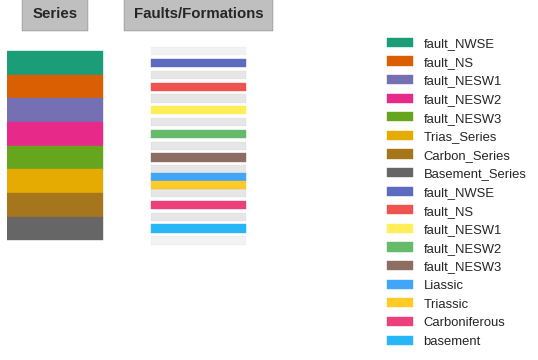

In [10]:
gp.get_sequential_pile(geo_data)

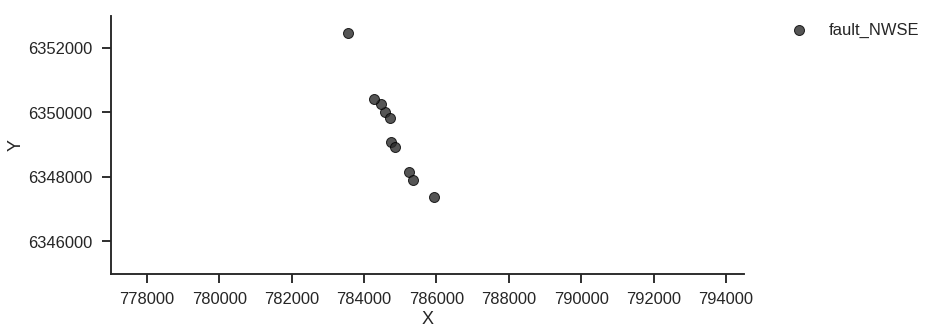

In [11]:
gp.plotting.plot_data(geo_data,direction='z',data_type='interfaces',series='fault_NWSE')
#plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\clusteredorient_only.png", format='png', dpi=1000)

In [12]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  dtype='float32',theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  5


### Choosing which series a fault offsets

In [13]:
faults1=['fault_NESW1',
 'fault_NESW2',
 'fault_NESW3']
faults2=['fault_NS',
 'fault_NWSE']

In [14]:
geo_data.faults_relations.loc[faults1,['Trias_Series']] = True
geo_data.faults_relations.loc[faults2,['Trias_Series']] = True
geo_data.faults_relations.loc[faults2,['Carbon_Series']] = True
geo_data.faults_relations

,fault_NWSE,fault_NS,fault_NESW1,fault_NESW2,fault_NESW3,Trias_Series,Carbon_Series,Basement_Series
fault_NWSE,False,False,False,False,False,True,True,False
fault_NS,False,False,False,False,False,True,True,False
fault_NESW1,False,False,False,False,False,True,False,False
fault_NESW2,False,False,False,False,False,True,False,False
fault_NESW3,False,False,False,False,False,True,False,False
Trias_Series,False,False,False,False,False,False,False,False
Carbon_Series,False,False,False,False,False,False,False,False
Basement_Series,False,False,False,False,False,False,False,False


In [15]:
interp_data.update_interpolator(geo_data)

CPU 1 core = 2,63

GPU = ,12

In [16]:
lith_block, fault_block = gp.compute_model(interp_data)

## Adding topography

In [17]:
topo_plotting = np.load('topo_plotting.npy')

In [18]:
from gempy.utils import topography
elevation = topography.DEM(xyzarray=topo_plotting, geodata=geo_data)#,output_path = folder,interpdata=interp_data)

Define path to raster file


../../../gempy/utils/topography.py:24: UserWarning: gdal package is not installed. No support for raster functions
  warnings.warn("gdal package is not installed. No support for raster functions")


### Creating figures

(50, 50)


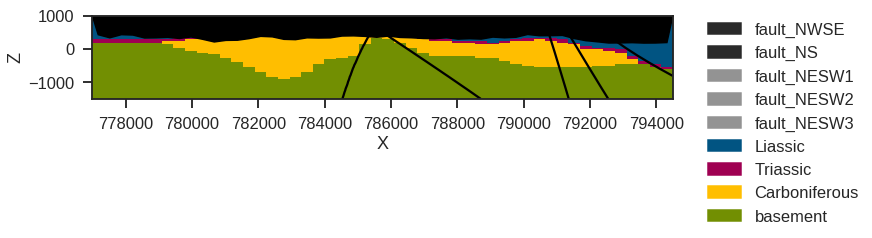

In [19]:
n, direc = 18, 'y'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

(50, 50)


/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


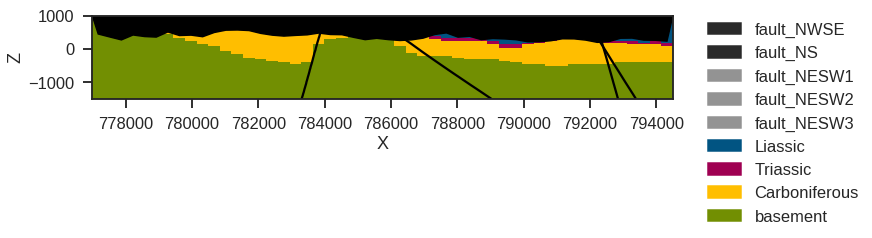

In [20]:
n, direc = 40, 'y'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

(50, 50)


/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


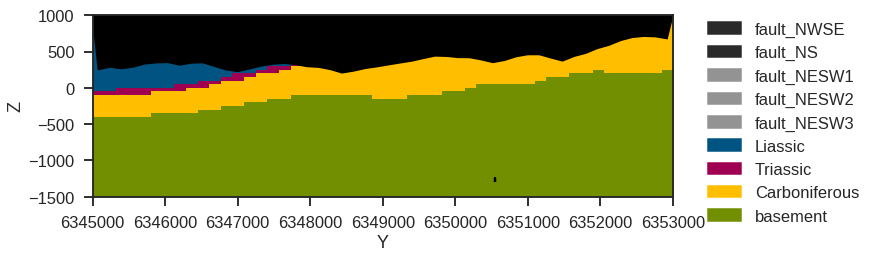

In [21]:
n, direc = 9, 'x'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

(50, 50)


/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


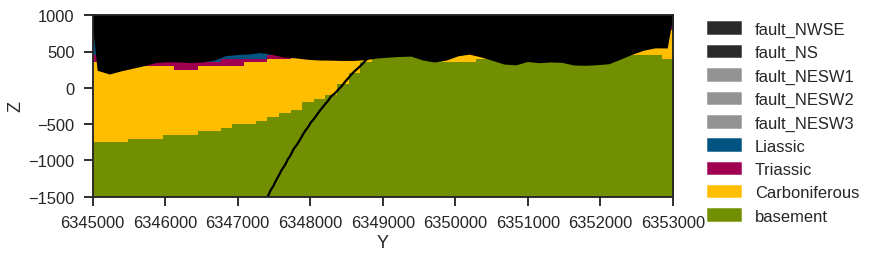

In [22]:
n, direc = 22, 'x'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

(50, 50)


/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


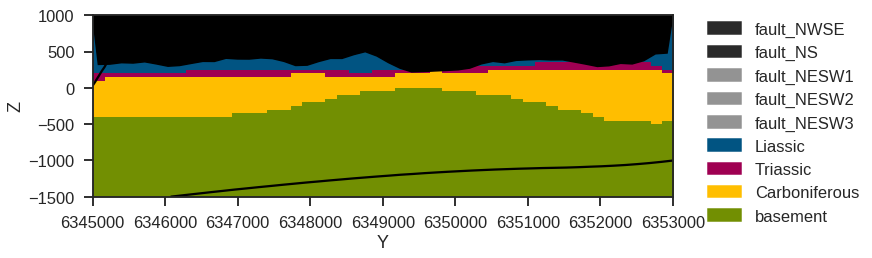

In [23]:
n, direc = 32, 'x'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

(50, 50)


/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/elisa/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


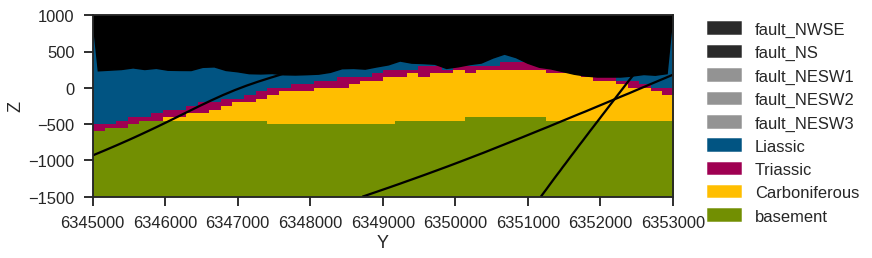

In [24]:
n, direc = 44, 'x'
gp.plot_section(geo_data, lith_block[0], cell_number=n,  direction=direc, plot_data=False, topography=elevation)
gp.plotting.extract_countours(geo_data, interp_data, fb=fault_block, cell_number=n,  direction=direc)
plt.savefig('/home/elisa/elisa/section_'+str(n)+direc+'_model'+str(model_num)+param)

#### GeologicalMap

In [25]:
# We stack the topograghy and the regular grid values
topo_data = np.load('surface_coordinates.npy')
x_to_int = np.vstack((topo_data, geo_data.grid.values))

In [26]:
lith_complete, _ = gp.compute_model_at(x_to_int, interp_data)
lith_map = lith_complete[0][:320*700]
lith_mesh = lith_complete[0][320*700:]

##### Plot section of the mesh

(50, 50)


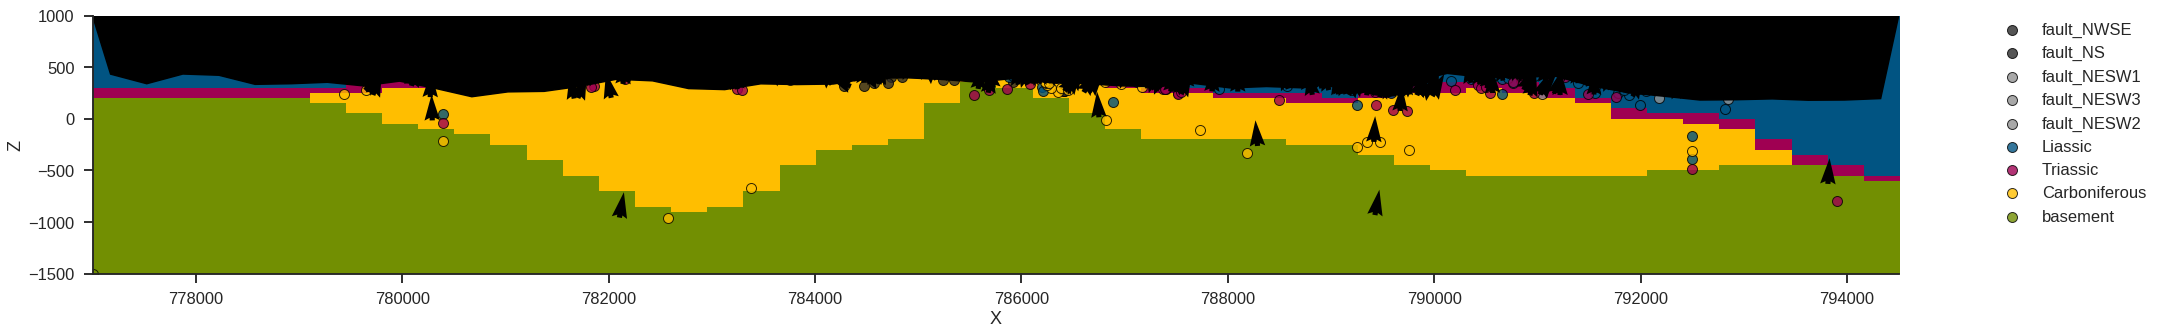

In [27]:
gp.plot_section(geo_data, lith_mesh, 18, plot_data=True, topography=elevation)

##### Plot geological map

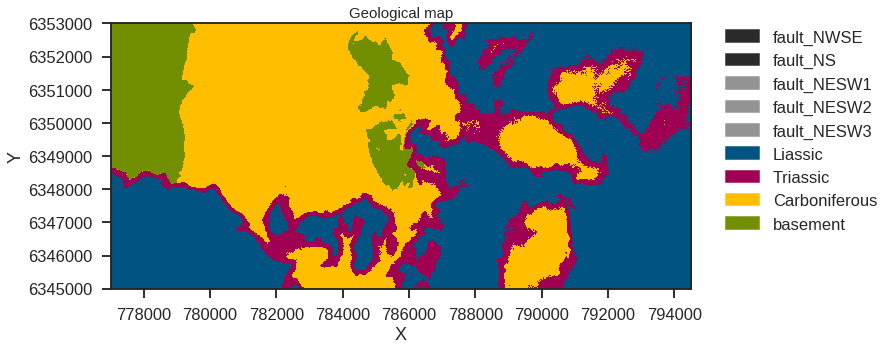

In [28]:
gp.plotting.plot_map(geo_data, geomap=np.flip(lith_map.reshape(320,700),axis=0))
plt.savefig('/home/elisa/elisa/map_'+str(model_num)+param)

### Creating vMF distributions for each orientation

In [29]:
import gempy.utils.fishdist as fish

for some purposes spherecluster package would be good (or I copy the respective file?!


In [30]:
def create_vMF_list(orientdf, datatype = 'all'):
    vMF_list=[]
    if datatype == 'faultsonly':
        df = orientdf[orientdf['isFault']==True]
    elif datatype == 'lithonly':
        df = orientdf[orientdf['isFault']==False]
    elif datatype == 'all':
        df = orientdf
    else:
        print('bist du behindert?')
    for e, i in df[['G_x', 'G_y', 'G_z', 'kappa']].iterrows():
        vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=i['kappa']))
    return vMF_list

In [79]:
def calculate_models(n_iter, geo_data, interp_data, x_to_int,datatype='all'):
    interp_data.update_interpolator(geo_data) #make it virgin again
    # initialize counters
    lith_complete, _ = gp.compute_model_at(x_to_int, interp_data)
    lith_map = lith_complete[0][:320*700]
    lith_mesh = lith_complete[0][320*700:]
    ### get number of different lithologies
    lith_id = np.unique(np.round(lith_mesh).astype(int))
    ### round blocks
    block_map  = np.round(lith_map).astype(int)
    block_mesh  = np.round(lith_mesh).astype(int)
    ### create one array for every lithology to count frequency
    count_map = np.zeros((len(lith_id), block_map.shape[0]))
    count_mesh = np.zeros((len(lith_id), block_mesh.shape[0]))
    
    vMF_list=create_vMF_list(geo_data.orientations,datatype=datatype)
    
    for a in range(0,n_iter):
        new_orientations = np.vstack(list(map(lambda x: x.sample(num_samples=1, direct_output=True)[0], vMF_list)))
        # Modifing the rescale dataframe
        #print(len(new_orientations))
        if datatype == 'faultsonly':
            print(len(new_orientations))
            cond = interp_data.geo_data_res.orientations['isFault']==True
        elif datatype == 'lithonly': 
            cond = interp_data.geo_data_res.orientations['isFault']==False                                       
        elif datatype == 'all': 
            cond=interp_data.geo_data_res.orientations.index
            #interp_data.geo_data_res.orientations[['G_x', 'G_y', 'G_z']] = new_orientations
        else:
            print('nein.')
            break
        interp_data.geo_data_res.orientations.loc[cond, ['G_x', 'G_y', 'G_z']] = new_orientations
                                                  
        print(interp_data.geo_data_res.orientations[interp_data.geo_data_res.orientations['isFault']==True][['G_x', 'G_y', 'G_z']])
        interp_data.geo_data_res.calculate_orientations()
        
        #compute model
        lith_complete, _ = gp.compute_model_at(x_to_int, interp_data)
        lith_map = lith_complete[0][:320*700]
        lith_mesh = lith_complete[0][320*700:]

        # update probability fields
        block_map  = np.round(lith_map).astype(int)
        block_mesh  = np.round(lith_mesh).astype(int)
        #print(block_mesh.shape)
        for i, l_id in enumerate(lith_id): #enumerate through all liths
            count_map[i][block_map == l_id] += 1 #sum up frequency
            count_mesh[i][block_mesh == l_id] += 1 

    prob_map = count_map/n_iter
    prob_mesh = count_mesh/n_iter
    
    return prob_map, prob_mesh

In [93]:
i = 100

In [94]:
faultsmap,faultsmesh = calculate_models(i,geo_data, interp_data, x_to_int,datatype='faultsonly')
lithmap, lithmesh = calculate_models(i,geo_data, interp_data, x_to_int,datatype='lithonly')
allmap, allmesh = calculate_models(i, geo_data,interp_data, x_to_int,datatype='all')

8
        G_x       G_y       G_z
0 -0.811850 -0.376168  0.446539
1 -0.975818 -0.004691  0.218536
2 -0.782555  0.077455  0.617745
3 -0.921673  0.213818  0.323729
4  0.200071  0.303032  0.931742
5  0.673843 -0.234093  0.700811
6  0.751325 -0.303021  0.586250
7  0.821574 -0.509471  0.255843
8
        G_x       G_y       G_z
0 -0.953032 -0.172140  0.249193
1 -0.987973  0.088474  0.126811
2 -0.909515 -0.254846  0.328384
3 -0.845723 -0.259887  0.466059
4  0.633231  0.371359  0.679052
5  0.794529 -0.530504  0.295448
6  0.748561 -0.255515  0.611857
7  0.910612 -0.411521  0.037908
8
        G_x       G_y       G_z
0 -0.894119 -0.266402 -0.359973
1 -0.959995 -0.149177  0.236972
2 -0.738993 -0.558066  0.377428
3 -0.920666  0.094280  0.378794
4  0.563248  0.306735  0.767246
5  0.472385 -0.415527  0.777296
6  0.781277 -0.142239  0.607762
7  0.966728 -0.183817  0.177898
8
        G_x       G_y       G_z
0 -0.712078  0.074571  0.698129
1 -0.936755 -0.344473  0.061872
2 -0.662222 -0.748244  0.039912


8
        G_x       G_y       G_z
0 -0.883536 -0.397098  0.248348
1 -0.913821  0.137105  0.382275
2 -0.618596 -0.700576  0.355714
3 -0.654510 -0.629165  0.419247
4  0.431279  0.431400  0.792397
5  0.629907 -0.317805  0.708673
6  0.965346  0.074719  0.250048
7  0.969938 -0.161947  0.181642
8
        G_x       G_y       G_z
0 -0.864949 -0.424943  0.266994
1 -0.989665 -0.011334  0.142952
2 -0.800256 -0.506036 -0.321744
3 -0.960538  0.010673  0.277943
4  0.801429  0.528062  0.280823
5  0.616359 -0.317216  0.720746
6  0.820918 -0.285376  0.494625
7  0.920670  0.007496  0.390270
8
        G_x       G_y       G_z
0 -0.921653 -0.387728 -0.014928
1 -0.777132  0.060498  0.626423
2 -0.520943 -0.841344  0.144078
3 -0.905209 -0.406111  0.125183
4  0.633860  0.354217  0.687570
5  0.822714 -0.024035  0.567947
6  0.724418 -0.240106  0.646194
7  0.640102 -0.740657  0.204200
8
        G_x       G_y       G_z
0 -0.971127  0.158693 -0.178127
1 -0.937856 -0.195187  0.286928
2 -0.682380 -0.704995  0.193236


8
        G_x       G_y       G_z
0 -0.781894 -0.608016  0.137694
1 -0.602871 -0.046637  0.796474
2 -0.942948 -0.316594  0.103042
3 -0.874936  0.312737  0.369705
4 -0.033020  0.158359  0.986829
5  0.785326 -0.227435  0.575792
6  0.936782  0.150736  0.315783
7  0.810767 -0.459702  0.362396
8
        G_x       G_y       G_z
0 -0.640315 -0.336027  0.690712
1 -0.889570  0.456795  0.001619
2 -0.928265 -0.258844  0.267067
3 -0.935993  0.083134  0.342060
4  0.333444  0.673161  0.660052
5  0.411524 -0.268658  0.870903
6  0.850268 -0.383607  0.360401
7  0.939058 -0.329680  0.097374
8
        G_x       G_y       G_z
0 -0.993799  0.054293  0.097036
1 -0.869782  0.186284  0.456923
2 -0.723863 -0.676136  0.137344
3 -0.908248 -0.265173  0.323681
4  0.470410  0.143228  0.870747
5  0.534851 -0.253875  0.805904
6  0.761913 -0.553358  0.336576
7  0.999371 -0.029381  0.019867
8
        G_x       G_y       G_z
0 -0.908389 -0.416590  0.035805
1 -0.646175 -0.287942  0.706786
2 -0.704769 -0.531557  0.469838


8
        G_x       G_y       G_z
0 -0.992584 -0.115170  0.038890
1 -0.989983 -0.133603 -0.045655
2 -0.849300 -0.527745 -0.013224
3 -0.911568  0.071404  0.404901
4  0.563648  0.213378  0.797979
5  0.724564 -0.157178  0.671045
6  0.988652 -0.096370  0.115237
7  0.710170 -0.564681  0.420468
8
        G_x       G_y       G_z
0 -0.776041 -0.626657 -0.071142
1 -0.976653 -0.214792 -0.003576
2 -0.777686 -0.628169 -0.024645
3 -0.738310 -0.507342  0.444412
4  0.368692  0.149801  0.917402
5  0.484508 -0.446689  0.752145
6  0.898775 -0.204856  0.387605
7  0.794213 -0.506706  0.335372
8
        G_x       G_y       G_z
0 -0.936112 -0.271171 -0.223965
1 -0.883952 -0.280881  0.373811
2 -0.856617 -0.515951  0.001455
3 -0.868696 -0.443810  0.220001
4  0.715265  0.346195  0.607079
5  0.572834 -0.469668  0.671768
6  0.781058 -0.243973  0.574827
7  0.854441 -0.514065  0.075291
8
        G_x       G_y       G_z
0 -0.835780 -0.391682  0.384783
1 -0.984303 -0.146796  0.097967
2 -0.751392 -0.508540  0.420473


        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910

        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910

        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910617 -0.231944  0.342020
4  0.526541  0.368688  0.766044
5  0.600094 -0.230354  0.766044
6  0.852869 -0.150384  0.500000
7  0.907673 -0.330366  0.258819
        G_x       G_y       G_z
0 -0.925417 -0.336824  0.173648
1 -0.936117 -0.081900  0.342020
2 -0.844374 -0.412376  0.342020
3 -0.910

        G_x       G_y       G_z
0 -0.636234 -0.524394  0.565878
1 -0.945360  0.050323  0.322121
2 -0.742649 -0.465964  0.480988
3 -0.998144  0.046847 -0.038910
4  0.512655  0.338653  0.788986
5  0.479572 -0.157355  0.863279
6  0.644916 -0.404175  0.648634
7  0.929776 -0.280035  0.238949
        G_x       G_y       G_z
0 -0.911907 -0.358864  0.199105
1 -0.957137 -0.216350  0.192568
2 -0.767239 -0.572496  0.289126
3 -0.980948 -0.182696  0.066060
4  0.192367  0.433749  0.880259
5  0.513362 -0.308639  0.800750
6  0.903049 -0.107399  0.415895
7  0.939036 -0.255274  0.230318
        G_x       G_y       G_z
0 -0.983899  0.106002  0.143895
1 -0.921627  0.288904 -0.259109
2 -0.897341 -0.403284  0.179277
3 -0.854976 -0.061922  0.514958
4  0.383160 -0.205046  0.900636
5  0.780081 -0.092284  0.618835
6  0.664559 -0.119289  0.737652
7  0.892697 -0.220995  0.392751
        G_x       G_y       G_z
0 -0.871186 -0.377078  0.314400
1 -0.866232 -0.134267  0.481263
2 -0.619326 -0.180230  0.764168
3 -0.806

        G_x       G_y       G_z
0 -0.896263 -0.432847  0.096723
1 -0.776099 -0.081644  0.625304
2 -0.975851  0.154445  0.154473
3 -0.886810 -0.147886  0.437833
4  0.666825  0.572517  0.477041
5  0.635724  0.097614  0.765720
6  0.870895 -0.195595  0.450872
7  0.945807 -0.228171  0.231056
        G_x       G_y       G_z
0 -0.994086 -0.057465  0.092147
1 -0.785107 -0.026661  0.618786
2 -0.522748 -0.754048  0.397675
3 -0.887398 -0.207037  0.411898
4  0.558045  0.707609  0.433446
5  0.477840 -0.107789  0.871809
6  0.866509 -0.109896  0.486913
7  0.800353 -0.524468  0.290462
        G_x       G_y       G_z
0 -0.905250 -0.404116  0.131197
1 -0.830428 -0.450053  0.328394
2 -0.463952 -0.591830  0.659155
3 -0.632782 -0.337856  0.696736
4  0.271475  0.590500  0.760007
5  0.689900 -0.116817  0.714417
6  0.879576 -0.037583  0.474272
7  0.928827 -0.311157  0.201150
        G_x       G_y       G_z
0 -0.729929 -0.018017  0.683286
1 -0.774033 -0.434457  0.460564
2 -0.773864 -0.155967  0.613847
3 -0.803

        G_x       G_y       G_z
0 -0.918884 -0.255897  0.300282
1 -0.979684 -0.189551 -0.065500
2 -0.837103 -0.502147 -0.217042
3 -0.794384 -0.468424  0.386696
4  0.657220  0.201836  0.726171
5  0.679549 -0.342048  0.649012
6  0.880235  0.062738  0.470373
7  0.999863  0.015598 -0.005606
        G_x       G_y       G_z
0 -0.947539 -0.319639 -0.000919
1 -0.951138 -0.154489  0.267338
2 -0.743519 -0.404581  0.532441
3 -0.960862 -0.120514  0.249440
4  0.568487  0.479592  0.668441
5  0.597041 -0.096348  0.796404
6  0.556896  0.110826  0.823155
7  0.989071 -0.146487  0.016712
        G_x       G_y       G_z
0 -0.870751 -0.380931  0.310940
1 -0.871411 -0.086792  0.482814
2 -0.876045 -0.357086  0.324091
3 -0.979998 -0.153595  0.126542
4  0.503794  0.601109  0.620371
5  0.620424 -0.257896  0.740650
6  0.861794 -0.157232  0.482275
7  0.942883 -0.308648  0.125335
        G_x       G_y       G_z
0 -0.918797 -0.379755  0.107694
1 -0.610495 -0.449411  0.652169
2 -0.849857 -0.478081  0.221770
3 -0.971

        G_x       G_y       G_z
0 -0.978262 -0.199475  0.056693
1 -0.995269 -0.095011  0.020301
2 -0.889839 -0.451163  0.068112
3 -0.800997  0.009756  0.598589
4  0.730863  0.650084  0.207920
5  0.501188 -0.189833  0.844260
6  0.800473 -0.429763  0.417788
7  0.891434 -0.229613  0.390670
        G_x       G_y       G_z
0 -0.661616 -0.748840  0.038768
1 -0.928097  0.339088  0.153805
2 -0.835682 -0.196031  0.513037
3 -0.940124  0.076652  0.332102
4  0.405011  0.454662  0.793252
5  0.473538 -0.099796  0.875101
6  0.813560  0.041354  0.580008
7  0.950790 -0.135020  0.278870
        G_x       G_y       G_z
0 -0.956408 -0.214544 -0.198128
1 -0.994624 -0.082123  0.063081
2 -0.273423 -0.524024  0.806622
3 -0.521731 -0.039266  0.852206
4  0.790147  0.565693  0.235923
5  0.477590 -0.420554  0.771389
6  0.763062 -0.127824  0.633559
7  0.910973 -0.130703  0.391209
        G_x       G_y       G_z
0 -0.759504 -0.543484 -0.357463
1 -0.979421 -0.201797  0.003538
2 -0.593400 -0.789774  0.155351
3 -0.640

### Results

In [95]:
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

In [96]:
def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [97]:
iefaultsmap=calculate_ie_masked(faultsmap)
iefaultsmesh=calculate_ie_masked(faultsmesh)

ielithmap=calculate_ie_masked(lithmap)
ielithmesh=calculate_ie_masked(lithmesh)

ieallmap=calculate_ie_masked(allmap)
ieallmesh=calculate_ie_masked(allmesh)

In [98]:
from mpl_toolkits import axes_grid1

In [99]:
extent = np.array([777000, 794500, 6345000, 6353000, -1500, 1000])
def plot_block(block, cmap='viridis', direction = 'y', cell_number=18):
    block = block.reshape(50,50,50)
    if direction=='y':
        im = plt.imshow(block[:,cell_number,:].T, origin='lower', extent=extent[[0,1,4,5]],cmap=cmap)
    elif direction =='x':
        im = plt.imshow(block[:,:,cell_number].T, origin='lower', extent=extent[[2,3,4,5]],cmap=cmap)
    _add_colorbar(im)

def plot_map(geomap,cmap='viridis'):
    im = plt.imshow(geomap.reshape(320,700),cmap=cmap, extent=extent[[0,1,2,3]])
    _add_colorbar(im)

def _add_colorbar(im, aspect=20, pad_fraction=1, **kwargs):
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=2. / aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

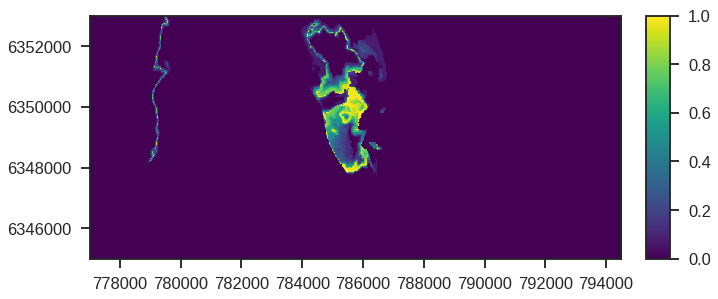

In [100]:
plot_map(iefaultsmap)

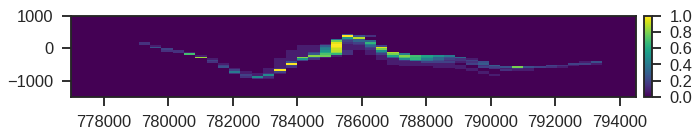

In [101]:
plot_block(iefaultsmesh)

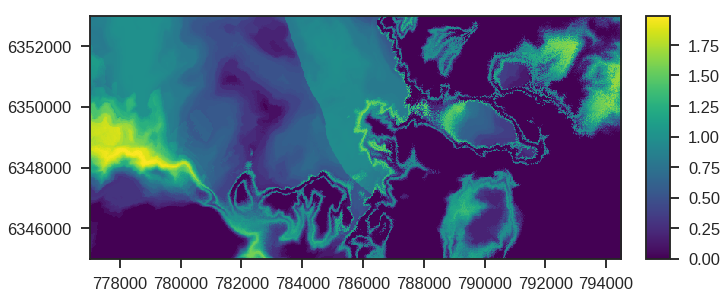

In [102]:
plot_map(ielithmap)

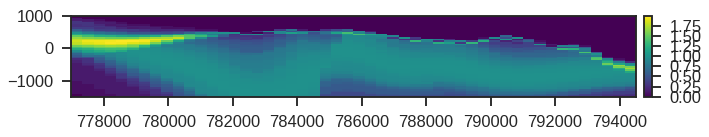

In [103]:
plot_block(ielithmesh)

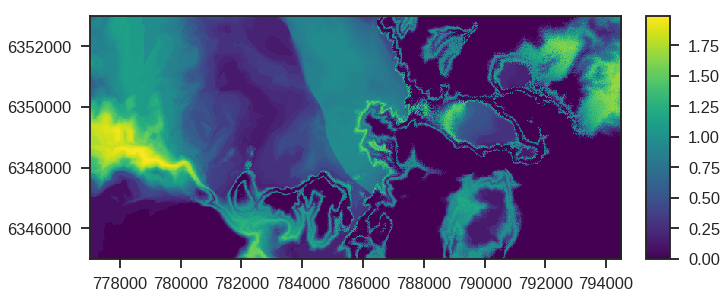

In [104]:
plot_map(ieallmap)

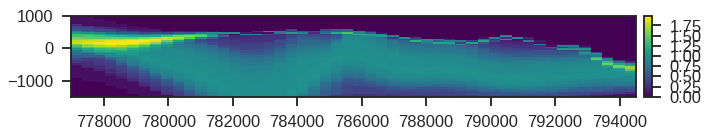

In [105]:
plot_block(ieallmesh)

### Save resulting probability/entropy fields

In [ ]:
spath_map_prob_field = '/home/elisa/elisa/map_prob_model'+str(model_num)+param+'_n'+str(n_iter)
spath_model_prob_field = '/home/elisa/elisa/model_prob_model'+str(model_num)+param+'_n'+str(n_iter)
spath_map_ie = '/home/elisa/elisa/map_ie_model'+str(model_num)+param+'_n'+str(n_iter)
spath_model_ie = '/home/elisa/elisa/model_ie_model'+str(model_num)+param+'_n'+str(n_iter)

In [ ]:
spath_map_prob_field

In [ ]:
np.save(spath_map_prob_field,prob_map)
np.save(spath_model_prob_field,prob_mesh)
np.save(spath_map_ie,ie_map)
np.save(spath_model_ie,ie_mesh)

In [17]:
def extract_countours(interp_data, fb,lb=None):   
    lith_colors = ['#000000','#000000','#000000','#000000','#000000']
    cm = matplotlib.colors.LinearSegmentedColormap.from_list('lith_colors', lith_colors, N=5)
    
    n_faults = int(fb.shape[0]/2)
    level = []
    block_id=[]
    
    all_levels = interp_data.potential_at_interfaces[np.where(interp_data.potential_at_interfaces != 0)]
    
    for i in range(fb.shape[0]):
        if i%2:
            block_id.append(i)
    
    for i in range(len(block_id)):
        cp = plt.contour(np.flip(fb[block_id[i]].reshape(320, 700),axis=0),0,
            extent=geo_data.extent[[0,1,2,3]],levels=all_levels[i], cmap=cm)
    if lb is not None:
        cp2 = plt.contour(np.flip(lb[block_id[i]].reshape(320, 700),axis=0),0,
                extent=geo_data.extent[[0,1,2,3]],levels=np.sort(all_levels[len(block_id):]),cmap=cm)

#print(all_levels) 
    

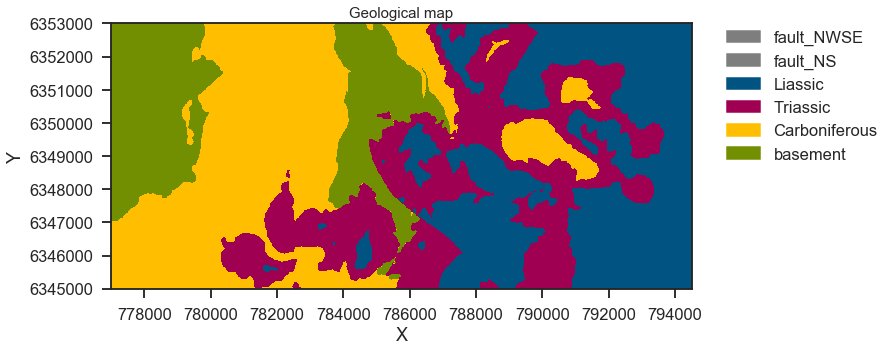

In [97]:
gp.plotting.plot_map(geo_data, geomap=np.flip(lith_map[0].reshape(320, 700),axis=0))
#extract_countours(interp_data,fault_map)
plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_filtered_b2.png", format='png', dpi=1000)

In [56]:
# only fault uncertainty
if inputdat == 'faults':
    @pymc.deterministic(trace=True)
    def input_data(value=0,geo_data_const=geo_data_const,
                   geo_data_stoch_init = geo_data_stoch_init, orient_modifier = orient_modifier):

        geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
        #print(geo_data_stoch.shape)
        geo_data_stoch_orient = geo_data_stoch_init.orientations[["X", "Y", "Z","G_x", "G_y", "G_z","formation",'kappa',
                                               'dip', 'azimuth', 'polarity','isFault']]

        fault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == True]
        means = geo_data_const.orientations[geo_data_const.orientations['isFault'] == True][['G_x','G_y','G_z']]
        notfault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == False]

        for i in fault_df.index:
           
            mean = means.loc[i]
            form = geo_data_stoch_orient.loc[i]['formation']
            kappa = geo_data_stoch_orient.loc[i]['kappa']

            fish = vMF(mean = mean, kappa = kappa)
            #print(fish.mean)
            xyz, azdip = fish.sample(direct_output=True,num_samples=n_iter)

            fault_df.loc[i, ['G_x','G_y','G_z']] = xyz[int(orient_modifier)]
            fault_df.loc[i, ['azimuth','dip']] = azdip[int(orient_modifier)]

        geo_orientations = pn.concat((fault_df,notfault_df))
        geo_orient = geo_orientations[["X", "Y", "Z","G_x", "G_y", "G_z", 'dip', 'azimuth', 'polarity']]
        #print(geo_orientations)
        return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_orient]
    
    
elif inputdat == 'all':
        # all uncertainty values of df
    @pymc.deterministic(trace=True)
    def input_data(value=0,geo_data_const=geo_data_const,
                   geo_data_stoch_init = geo_data_stoch_init, orient_modifier = orient_modifier):

        geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
        #print(geo_data_stoch.shape)
        geo_data_stoch_orient = geo_data_stoch_init.orientations[["X", "Y", "Z","G_x", "G_y", "G_z","formation",'kappa',
                                               'dip', 'azimuth', 'polarity','isFault']]
        
        means = geo_data_const.orientations[['G_x','G_y','G_z']]
        #fault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == True]
        #notfault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == False]
        
        for i in geo_data_stoch_orient.index:

            mean = means.loc[i]
            form = geo_data_stoch_orient.loc[i]['formation']
            kappa = geo_data_stoch_orient.loc[i]['kappa']

            fish = vMF(mean = mean, kappa = kappa)
            #print(fish.mean)
            xyz, azdip = fish.sample(direct_output=True,num_samples=n_iter)

            geo_data_stoch_orient.loc[i, ['G_x','G_y','G_z']] = xyz[int(orient_modifier)]
            geo_data_stoch_orient.loc[i, ['azimuth','dip']] = azdip[int(orient_modifier)]

        #geo_orientations = pn.concat((fault_df,notfault_df))
        geo_orient = geo_data_stoch_orient[["X", "Y", "Z", "G_x", "G_y", "G_z", 'dip', 'azimuth', 'polarity']]
        #print(geo_orientations)
        return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_orient]

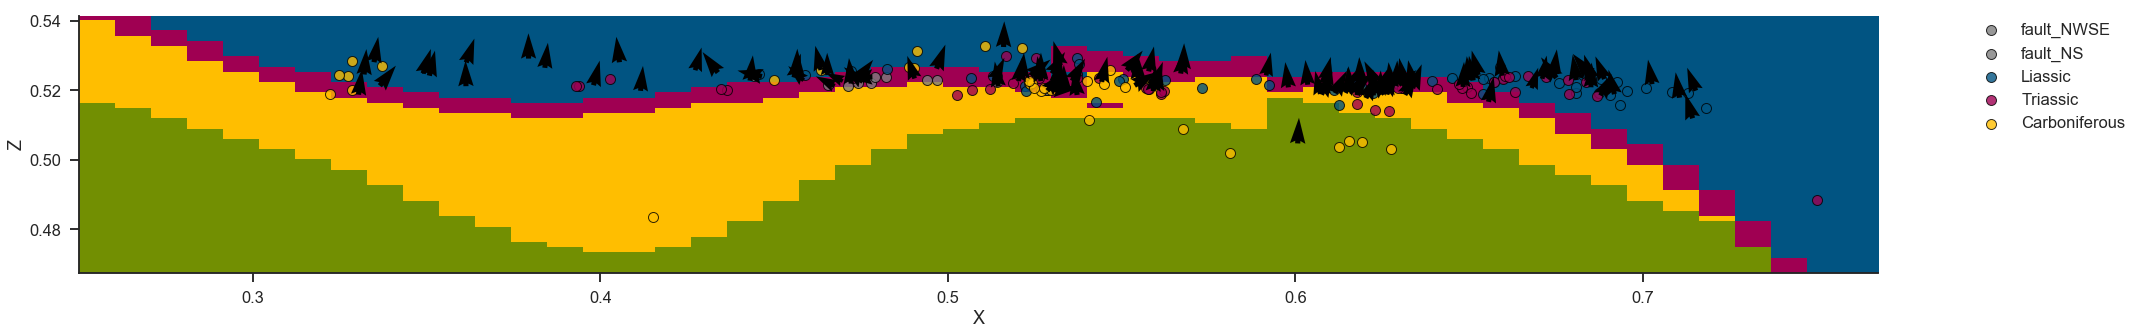

In [57]:
@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=True):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]

    interp_data.geo_data_res.orientations[["X", "Y", "Z","G_x", "G_y", "G_z", 
                                           'dip', 'azimuth', 'polarity']] = input_data[1] 

    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        #print(lb)
        if True:
            gp.plot_section(interp_data.geo_data_res, lb[0], 0, direction = 'y',plot_data=True)
            #print(interp_data.geo_data_res.interfaces["X"]) 
            
            return lb,fb

    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
            return np.zeros_like(lith_block), np.zeros_like(fault_block)

In [58]:
params = [input_data, gempy_model,orient_modifier] 
model = pymc.Model(params)

In [59]:
dbname = "C:\\Users\\elisa\\Documents\\git\\elthesis\\notebooks\\databases\\final\\Model3_filt_1102_i"+str(n_iter)+".hdf5"

In [60]:
dbname

'C:\\Users\\elisa\\Documents\\git\\elthesis\\notebooks\\databases\\final\\Model3_filt_1102_i30.hdf5'

In [61]:
RUN = pymc.MCMC(model, db="hdf5",dbname = dbname)

In [62]:
RUN.sample(iter=n_iter, verbose=0)

 [--                6%                  ] 2 of 30 complete in 2.3 sec[---              10%                  ] 3 of 30 complete in 4.6 sec[-----            13%                  ] 4 of 30 complete in 6.8 sec[------           16%                  ] 5 of 30 complete in 9.0 sec[-------          20%                  ] 6 of 30 complete in 11.1 sec[--------         23%                  ] 7 of 30 complete in 13.3 sec[----------       26%                  ] 8 of 30 complete in 15.5 sec[-----------      30%                  ] 9 of 30 complete in 17.7 sec[------------     33%                  ] 10 of 30 complete in 20.1 sec[-------------    36%                  ] 11 of 30 complete in 22.3 sec[---------------  40%                  ] 12 of 30 complete in 24.5 sec[---------------- 43%                  ] 13 of 30 complete in 26.6 sec[-----------------46%                  ] 14 of 30 complete in 28.9 sec[-----------------50%                  ] 15 of 30 complete in 31.1 sec[-----------------53%          

### Posterior

In [63]:
import importlib
importlib.reload(gp.posterior_analysis_elisa )

<module 'gempy.posterior_analysis_elisa' from 'C:\\Users\\elisa\\Documents\\git\\gempy\\gempy\\posterior_analysis_elisa.py'>

In [64]:
from gempy.posterior_analysis_elisa import Posterior

In [65]:
post = Posterior(dbname,entropy=True,interpdata=interp_data,geodata=geo_data, topography=elevation)

Lithology probability for all post models are calculated. Based on the model complexity and the number of iterations, this could take a while


In [74]:
norm = matplotlib.colors.Normalize(post.map_ie.min(),post.map_ie.max())

In [73]:
post.map_ie.max(),post.map_ie.min()

(1.7539845481434939, 0.0)

In [93]:
iemap=np.flip(post.map_ie.reshape(320, 700),axis=0)
iemap2=post.map_ie.reshape(320, 700)

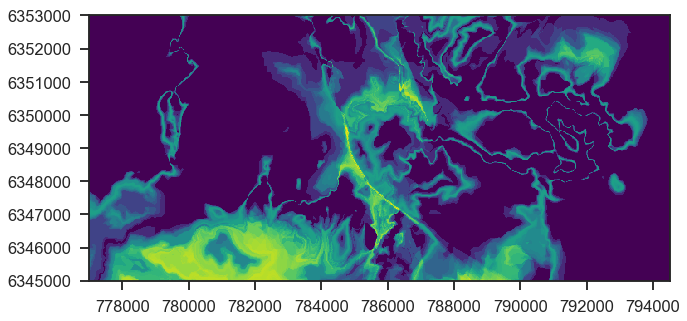

In [99]:
plt.imshow(iemap2,cmap='viridis',extent=geo_data.extent[:4])
plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_entropyflip2.png", format='png', dpi=1000)

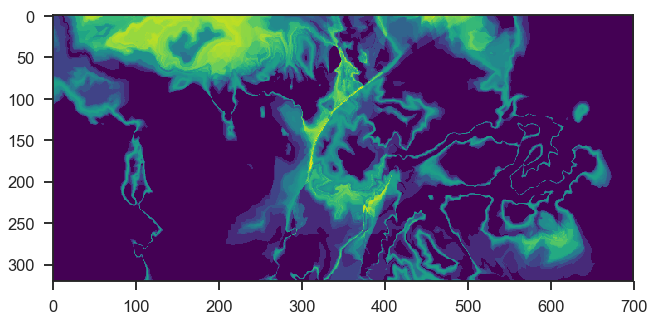

In [86]:
#gp.plotting.plot_data(geo_data,direction='z')
plt.imshow(iemap,cmap='viridis')
#plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_entropy.png", format='png', dpi=1000)

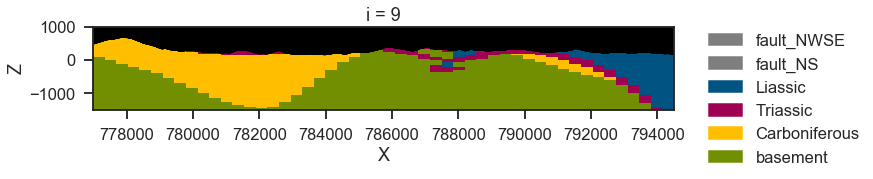

In [92]:
for i in range(0,10):
    post.plot_section(iteration=i,block='lith',fault=False)
    plt.title("i = %.d"%i)
    plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\post_y25_nofault"+str(i))

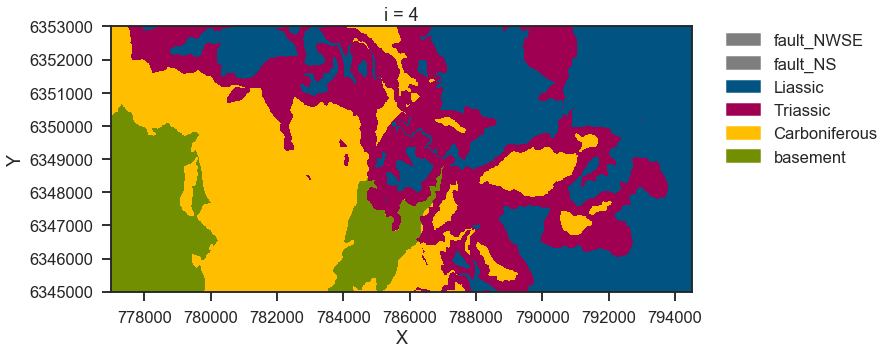

In [101]:
for i in range(0,5):
    post.plot_map(i)
    plt.title("i = %.d"%i)
    plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\post_map"+str(i))


In [66]:
post.plot_section_ie(block='lith',direction='y',cell_number=25,plot_data=True, plot_all_data=False)

AttributeError: 'Posterior' object has no attribute 'lb_ie'

KeyboardInterrupt: 

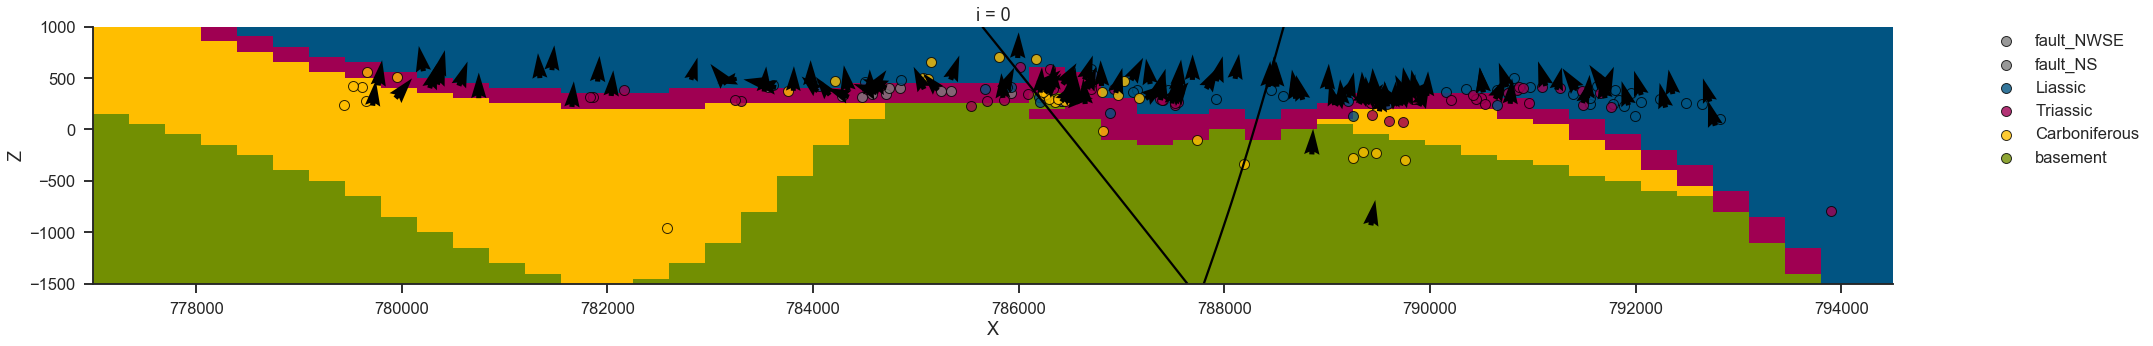

In [67]:
for i in range(0,2):
    post.plot_section(iteration=i,block='lith',fault=True,plot_data=True)
    plt.title("i = %.d"%i)
    #plt.savefig("C:\\Users\\elisa\\Documents\\git\\elthesis\\fig_export2\\entropy_orient"+str(i))

In [ ]:
post = Posterior(dbname,entropy=True,interpdata=interp_data,geodata=geo_data)

#### Topography

In [9]:
#topography
path_dtm='C:\\Users\\elisa\\Documents\\Ales\\DISTRIB_2018\\MNT\\MNT_Dx25m_ALES_L93.asc'
folder= "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\unwichtig"
xyz_path = "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\XYZ.csv"

In [10]:
from gempy.utils import topography

In [11]:
elevation = topography.DEM(path_dtm, geo_data,output_path = folder)

Extents of geo_data and DEM do not match. DEM is cropped and stored as C:\Users\elisa\Documents\git\MSc\GempyTopography\unwichtig_cropped_DEM.tif


Raster extent: [ 777000  794500 6345000 6353000     138     730] 
Raster resolution: [320 700]


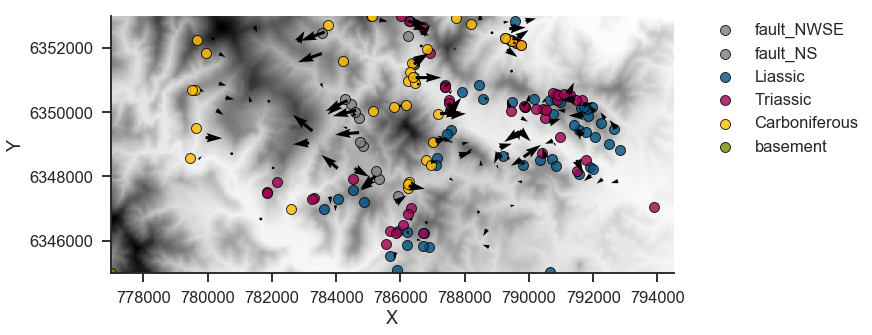

In [12]:
elevation.show(plot_data=True)

In [10]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  dtype='float64',theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2


In [11]:
lith_block, fault_block = gp.compute_model(interp_data)

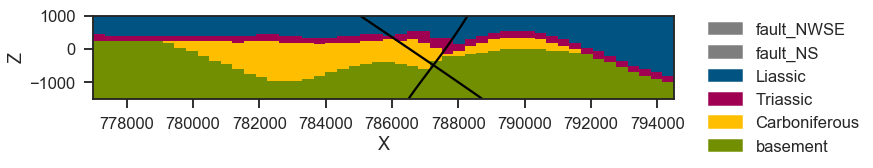

In [12]:
gp.plot_section(geo_data, lith_block[0], cell_number=5,  direction='y')#, topography=elevation)
gp.plotting.extract_countours(geo_data,interp_data,fb=fault_block,cell_number=5,direction='y')

In [ ]:
lith_map, fault_map = gp.compute_model_at(elevation.surface_coordinates[0], interp_data)

In [ ]:
lith_map[0].reshape(324, 588)

In [ ]:
gp.plotting.plot_map(geo_data, geomap=np.flip(lith_map[0].reshape(324, 588),axis=0),plot_data=True)
gp.plotting.extract_countours(geo_data,interp_data, fb=fault_map, lb=lith_map)

In [99]:
geo_data.resolution

array([30, 30, 30])

In [21]:
ver , sim = gp.get_surfaces(interp_data,lith_block[1],(fault_block[1], fault_block[3], fault_block[5]))

In [22]:
gp.plotting.plot_surfaces_3D(geo_data, ver, sim, plot_data=False)

closing vtk
